<a href="https://colab.research.google.com/github/sallihin/image-classification/blob/main/training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Fruits and Vegetable Image Classification

#### Import packages

In [1]:
# Import tensorflow and keras library
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
print("TF version:", tf.__version__)

# Import OS and pathlib module
import os
import pathlib

# Import additional libraries for plotting, eda
# !python -m pip install dask[bag] --upgrade
# !python -m pip install --upgrade Pillow
from dask import bag, diagnostics
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

TF version: 2.7.0


In [3]:
# Check if GPU is running
! nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-b55addb2-7708-2c33-a4af-604e8c75875f)


#### Load data

In [4]:
# Link to Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# File Directory
trainFolder = '/content/drive/MyDrive/DLOR/Assignment/data/train'
testFolder = '/content/drive/MyDrive/DLOR/Assignment/data/test'
validationFolder = '/content/drive/MyDrive/DLOR/Assignment/data/validation'

In [6]:
# Define image height and width
batch_size = 35
img_height = 500
img_width = 500

In [7]:
# Training Set
train_ds = tf.keras.utils.image_dataset_from_directory(
  trainFolder,
  validation_split=0,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3581 files belonging to 36 classes.


In [8]:
# Test Set
test_ds = tf.keras.utils.image_dataset_from_directory(
  testFolder,
  validation_split=0,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 359 files belonging to 36 classes.


#### Exploratory Data Analysis

In [9]:
total_images = len(list(pathlib.Path(trainFolder).glob('*/*.*'))) 
print('Total number of training images: {:,}'.format(total_images))

Total number of training images: 3,581


In [10]:
total_images = len(list(pathlib.Path(validationFolder).glob('*/*.*'))) 
print('Total number of test images: {:,}'.format(total_images))

Total number of test images: 351


In [12]:
# Target Classes
class_names = train_ds.class_names
print(class_names)

['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


In [13]:
print('Total number of categories: {}'.format(len(class_names)))

Total number of categories: 36


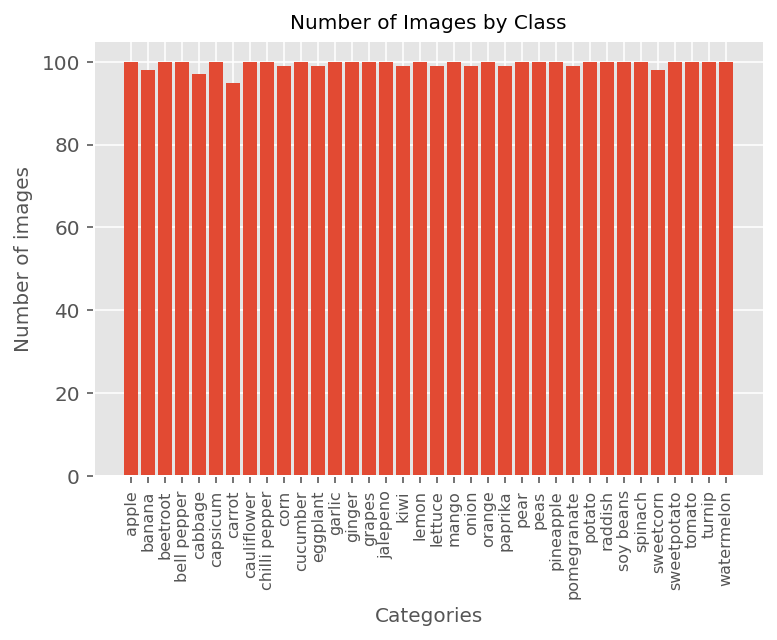

In [14]:
# Initialize a new dictionary
classes_len = {}

# Find out number of files in each directory
for i in class_names: 
  classes_len[i] = len(os.listdir(trainFolder + ('/') + i))

# Plot the chart
plt.bar(classes_len.keys(), classes_len.values());
plt.title("Number of Images by Class", fontsize = 10);
plt.xticks(rotation=90, fontsize = 8) 
plt.xlabel('Categories', fontsize = 10);
plt.ylabel('Number of images', fontsize = 10);

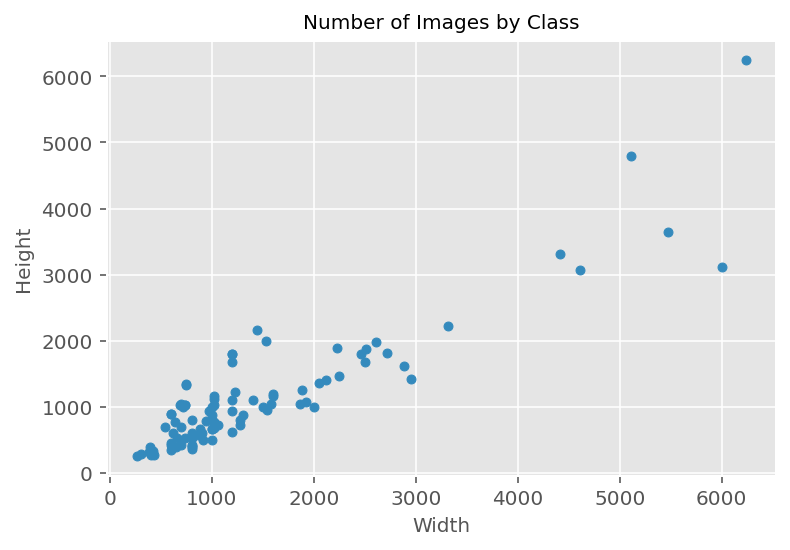

In [15]:
# Initialize a new dictionary
directories = {}

# Fill dictionary with category names as key and directory as value
for i in class_names: 
  directories[i] = trainFolder + ('/') + i + ('/')

# Gets dimension of RGB image
def get_dims(file):
  im = Image.open(file)
  arr = np.array(im)
  return arr.shape[0], arr.shape[1]

# For each key, value in directory, find each file's dimension
for n,d in directories.items():
  filepath = d
  filelist = [filepath + f for f in os.listdir(filepath)]
  dims = bag.from_sequence(filelist).map(get_dims)
  dims = dims.compute()

# Plot the chart
dim_df = pd.DataFrame(dims, columns=['height', 'width'])
sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
sizes.plot.scatter(x='width', y='height');
plt.title("Number of Images by Class", fontsize = 10);
plt.xlabel('Width', fontsize = 10);
plt.ylabel('Height', fontsize = 10);

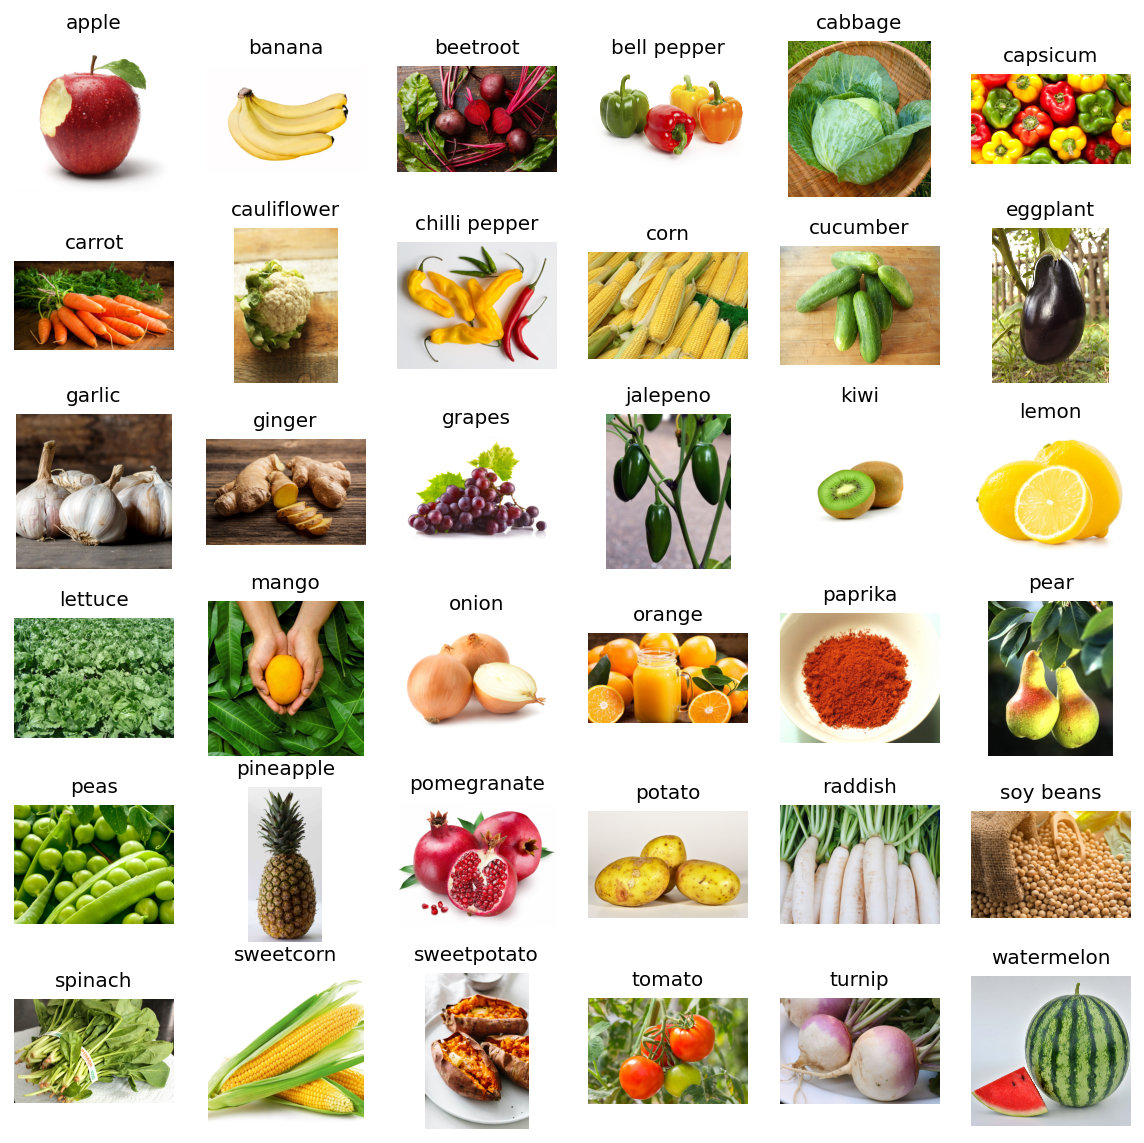

In [16]:
plt.figure(figsize=(10, 10))
for i in range(len(class_names)): 
  ax = plt.subplot(6, 6, i+1)
  first_image = Image.open(directories.get(class_names[i]) + 'Image_1.jpg')
  plt.imshow(first_image)
  plt.title(class_names[i],fontsize=10)
  plt.axis("off")

#### Model Training

In [113]:
num_classes = len(class_names)

# Instantiate the model
model = tf.keras.Sequential()

# Normalize the data
model.add(tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

# First set of CONV => RELU => POOL
model.add(tf.keras.layers.Conv2D(16, 3, padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D())

# Second set of CONV => RELU => POOL
model.add(tf.keras.layers.Conv2D(32, 3, padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D())

# Third set of CONV => RELU => POOL
model.add(tf.keras.layers.Conv2D(64, 3, padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D())

# Flatten into 1 dimension Multi Layer Perceptron 
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))

# Classifier
model.add(tf.keras.layers.Dense(num_classes)) 

# Exercise : Complete the activation function of the classifier
model.add(tf.keras.layers.Activation('softmax'))

In [114]:
model.compile(optimizer='adam',
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [115]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 500, 500, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 500, 500, 16)      448       
                                                                 
 activation_11 (Activation)  (None, 500, 500, 16)      0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 250, 250, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 250, 250, 32)      4640      
                                                                 
 activation_12 (Activation)  (None, 250, 250, 32)      0         
                                                      

In [116]:
epochs=10
model_log = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

Epoch 1/10
103/103 [==============================] - 98s 893ms/step - loss: 4.0711 - accuracy: 0.0600 - val_loss: 2.9247 - val_accuracy: 0.1866
Epoch 2/10
103/103 [==============================] - 94s 857ms/step - loss: 2.8866 - accuracy: 0.1935 - val_loss: 2.2420 - val_accuracy: 0.3482
Epoch 3/10
103/103 [==============================] - 94s 861ms/step - loss: 2.3433 - accuracy: 0.3351 - val_loss: 1.1799 - val_accuracy: 0.7187
Epoch 4/10
103/103 [==============================] - 93s 851ms/step - loss: 1.3941 - accuracy: 0.6102 - val_loss: 0.3707 - val_accuracy: 0.9220
Epoch 5/10
103/103 [==============================] - 93s 849ms/step - loss: 0.5525 - accuracy: 0.8461 - val_loss: 0.2714 - val_accuracy: 0.9499
Epoch 6/10
103/103 [==============================] - 92s 844ms/step - loss: 0.2729 - accuracy: 0.9411 - val_loss: 0.1313 - val_accuracy: 0.9749
Epoch 7/10
103/103 [==============================] - 93s 854ms/step - loss: 0.1546 - accuracy: 0.9665 - val_loss: 0.1192 - val_ac

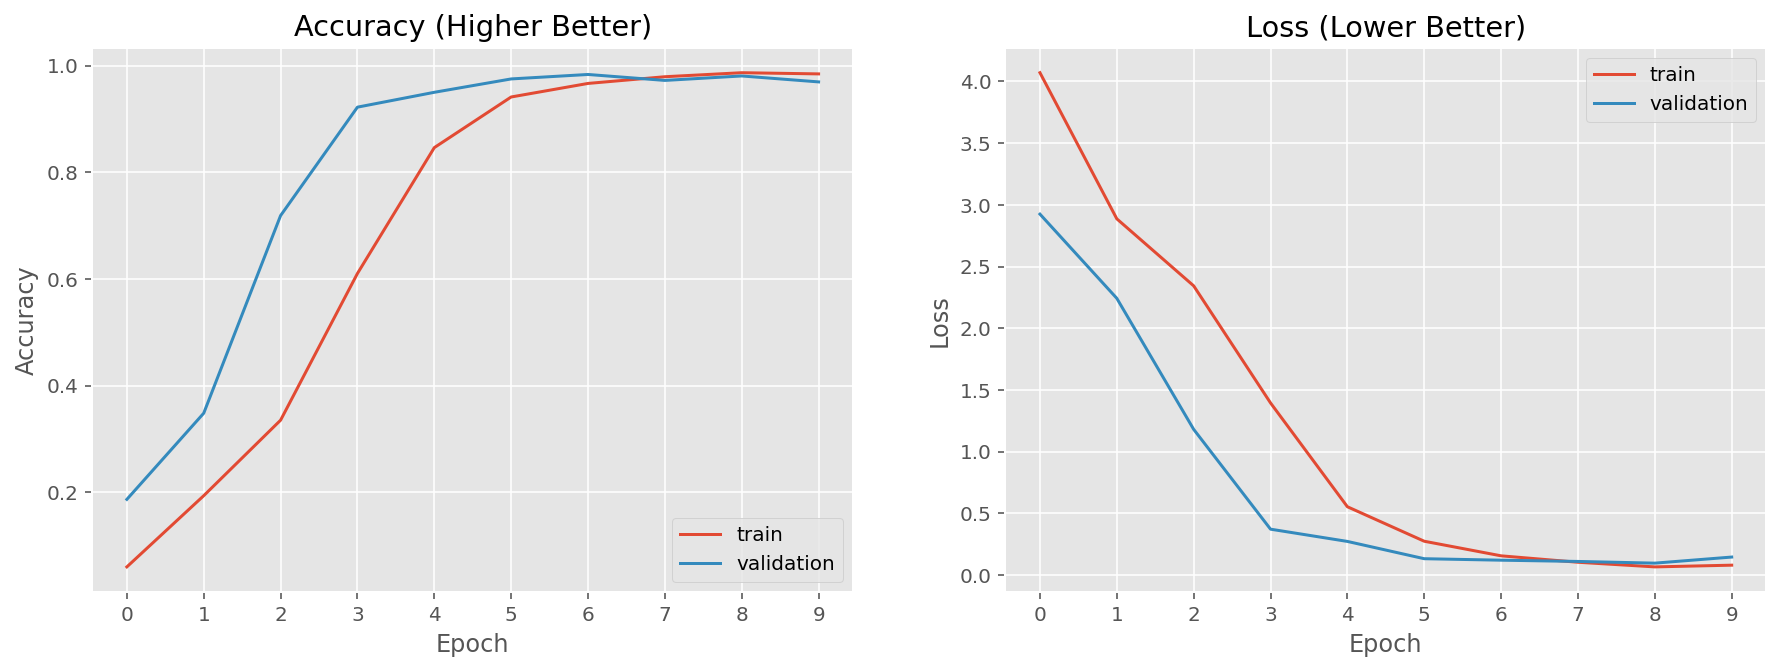

In [117]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [118]:
score = model.evaluate(train_ds, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.1594349443912506
Train accuracy: 0.9625802636146545


In [119]:
score = model.evaluate(test_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1446438878774643
Test accuracy: 0.9693593382835388


#### Testing The Model

In [120]:
# Predict using image from Google Drive
img = keras.preprocessing.image.load_img(validationFolder + '/banana/Image_5.jpg', target_size = (img_width, img_height))
img = keras.preprocessing.image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

model.predict(img)

array([[2.84840469e-04, 9.98783410e-01, 1.77464583e-14, 3.03315306e-09,
        8.91643773e-11, 2.49324827e-09, 6.57885508e-12, 7.77753085e-05,
        7.85246890e-09, 1.58720397e-07, 1.03418274e-10, 3.11639324e-15,
        8.47725278e-14, 2.01149586e-08, 2.97859742e-07, 5.85477160e-08,
        1.36545410e-07, 8.06819007e-04, 1.85564862e-11, 2.69266875e-05,
        1.34459674e-12, 3.88373928e-06, 8.40539374e-11, 1.28965448e-05,
        1.62686813e-13, 4.00195044e-10, 1.75369127e-12, 7.16584292e-11,
        1.14667865e-10, 1.17857529e-11, 2.46540316e-10, 2.79397750e-06,
        5.83996573e-10, 2.58937671e-08, 1.81060306e-11, 7.91980881e-09]],
      dtype=float32)

In [121]:
# Predict using image from Google Drive
img = keras.preprocessing.image.load_img(validationFolder + '/watermelon/Image_10.jpg', target_size = (img_width, img_height))
img = keras.preprocessing.image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

model.predict(img)

array([[2.76271663e-07, 2.65303339e-12, 6.63751970e-11, 2.45314391e-09,
        1.91977450e-16, 1.06154866e-05, 3.40695760e-09, 1.30424971e-09,
        1.15924369e-04, 1.88548894e-12, 2.45835558e-14, 2.88751122e-04,
        1.65441378e-07, 1.03089613e-10, 9.69084590e-10, 3.52003071e-09,
        9.48941446e-12, 7.28311456e-09, 3.62140092e-12, 7.83036917e-12,
        1.40294375e-07, 1.04986126e-08, 1.00377962e-04, 1.81775555e-08,
        3.55986096e-12, 1.75257455e-07, 1.53069723e-05, 2.10971440e-09,
        1.34176318e-07, 6.37196740e-10, 2.87331397e-14, 1.43652095e-08,
        4.40733317e-09, 1.03234008e-07, 8.46017585e-08, 9.99467909e-01]],
      dtype=float32)

#### Output Folders & Files

In [122]:
# createFolder Function
def createFolder (path):
  try:
    os.mkdir(path)
  except:
    print("The folder already exists:", path)
  else:
    print("The folder is created:", path)


In [123]:
# Logs Folder
logsFolder = '/content/drive/MyDrive/DLOR/Assignment/logs'

# Version Control
modelVersion = 'modelv1'    

# Output folder and files 
modelFolder = logsFolder + '/' + modelVersion + '/'
createFolder(modelFolder)
kerasFile = modelFolder + 'keras_model.h5'
labelFile = modelFolder + 'labels.txt'
tfliteFile = modelFolder + 'trained_model.tflite'

The folder already exists: /content/drive/MyDrive/DLOR/Assignment/logs/modelv1/


In [124]:
# Load the keras file, then convert
keras_model = tf.keras.models.load_model(kerasFile)
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
tflite_model = converter.convert()

# Save the model.
with open(tfliteFile, 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp92jwpsws/assets


INFO:tensorflow:Assets written to: /tmp/tmp92jwpsws/assets


In [125]:
testfile = validationFolder + '/jalepeno/Image_10.jpg'

!python /content/drive/MyDrive/DLOR/Assignment/label_image.py \
--model_file $tfliteFile \
--label_file $labelFile \
--input_mean 1. \
--input_std 1. \
--image $testfile

# https://stackoverflow.com/questions/56762749/tflite-model-converted-from-keras-h5-model-always-predicts-the-same-class-wi

0.999352: jalepeno
0.000436: watermelon
0.000165: grapes
0.000016: lettuce
0.000015: pear


In [126]:
testfile = validationFolder + '/watermelon/Image_5.jpg'

!python /content/drive/MyDrive/DLOR/Assignment/label_image.py \
--model_file $tfliteFile \
--label_file $labelFile \
--input_mean 1. \
--input_std 1. \
--image $testfile

0.999418: watermelon
0.000411: pomegranate
0.000050: raddish
0.000034: onion
0.000021: eggplant


In [127]:
testfile = validationFolder + '/grapes/Image_3.jpg'

!python /content/drive/MyDrive/DLOR/Assignment/label_image.py \
--model_file $tfliteFile \
--label_file $labelFile \
--input_mean 1. \
--input_std 1. \
--image $testfile

0.999985: grapes
0.000009: cauliflower
0.000002: orange
0.000002: soy beans
0.000001: pineapple


---

#### **References**

- Dana Rausch, 2021 - [EDA for Image Classification](https://medium.com/geekculture/eda-for-image-classification-dcada9f2567a)
- StackExchange, 2018 - [Exploratory Data Analysis with Image Dataset](https://datascience.stackexchange.com/questions/29223/exploratory-data-analysis-with-image-datset)
- Gaurav Singhal, 2020 - [Importing Image Data into NumPy Arrays](https://www.pluralsight.com/guides/importing-image-data-into-numpy-arrays)


##### **Dataset**

- Kaggle - [Fruits & Vegetables Image Recognition](https://www.kaggle.com/kritikseth/fruit-and-vegetable-image-recognition)


##### **Documentation & Libraries**

- [Tensorflow Image Classification](https://www.tensorflow.org/tutorials/images/classification#model_summary)
- [Dask - Parallel Computing](https://docs.dask.org/en/stable/) 
- [Python Imaging Library](https://pillow.readthedocs.io/)
